---
## General Framework

### What's the story?
 I was in high school attending public school in downtown Chicago. I remember sometimes being afraid of civil unrest, especially surrounding high-profile court cases and during COVID-19. I remember experiencing teacher strikes, crazy winter storms, and other volatile activity, thinking: is it still safe to take the L blue line train to school today?

### What data will I use?
 I will use the GDELT database to identify violent events. Specifically, I will pull events with the code **145X** from the GDELT Event Database. We'll first visualize the data and then decide how to build our model.

---

In [214]:
#%pip install db-dtypes


In [215]:
#%pip show google-cloud-bigquery


In [216]:
#%pip install google-cloud-bigquery


In [217]:
from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client with the project ID
client = bigquery.Client(project="civil-unrest-predictor")

# SQL query
query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
ORDER BY
    SQLDATE DESC
LIMIT
    100;
"""

# Execute the query
#query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Save the results to a CSV file
data.to_csv("chicago_violent_protests_subset.csv", index=False)
print("Results saved to 'chicago_violent_protests_subset.csv'")
data


Results saved to 'chicago_violent_protests_subset.csv'


,SQLDATE,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,20241206,145,"Chicago, Illinois, United States",41.8500,-87.6501,1.066667
1,20241202,145,"University Of Chicago, Illinois, United States",41.7898,-87.5998,-0.843289
2,20241202,145,"Chicago, Illinois, United States",41.8500,-87.6501,-7.840083
3,20241202,145,"University Of Chicago, Illinois, United States",41.7898,-87.5998,-0.843289
4,20241118,145,"Chicago, Illinois, United States",41.8500,-87.6501,-6.067678
...,...,...,...,...,...,...
3342,20150119,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.494577
3343,20150119,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.494577
3344,20150119,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.857143
3345,20150119,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.494577


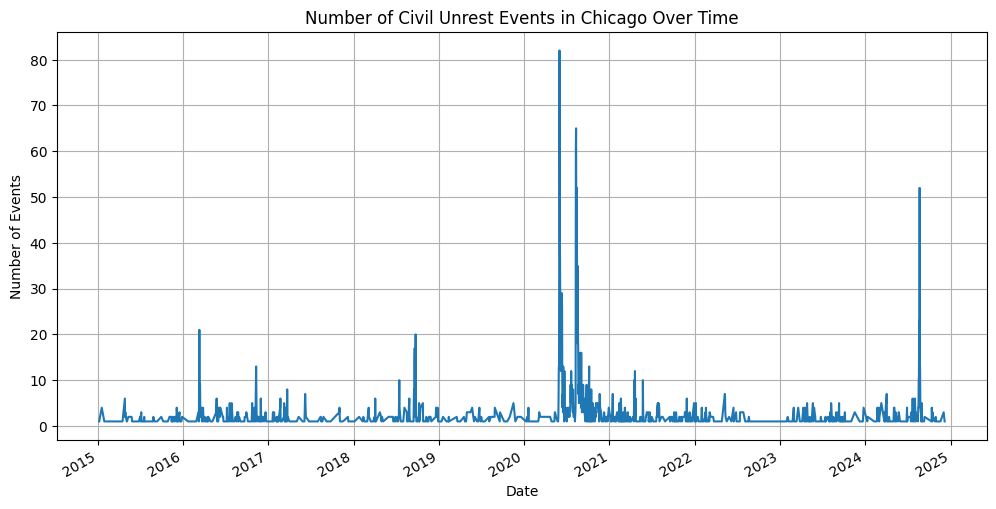

In [218]:
import matplotlib.pyplot as plt

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Plot the number of events over time
plt.figure(figsize=(12, 6))
data.groupby('SQLDATE').size().plot(kind='line')
plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

In [219]:
# Updated SQL query to pull data from January 2020 and limit to 2000 rows
query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20200101'
ORDER BY
    SQLDATE DESC
LIMIT
    2000;
"""

# Execute the updated query
#query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Save the results to a CSV file
data.to_csv("chicago_violent_protests_jan2020_subset.csv", index=False)
print("Results saved to 'chicago_violent_protests_jan2020_subset.csv'")
print(data.head())

Results saved to 'chicago_violent_protests_jan2020_subset.csv'
    SQLDATE EventCode                              ActionGeo_FullName  \
0  20241206       145                Chicago, Illinois, United States   
1  20241202       145  University Of Chicago, Illinois, United States   
2  20241202       145                Chicago, Illinois, United States   
3  20241202       145  University Of Chicago, Illinois, United States   
4  20241118       145                Chicago, Illinois, United States   

   ActionGeo_Lat  ActionGeo_Long   AvgTone  
0        41.8500        -87.6501  1.066667  
1        41.7898        -87.5998 -0.843289  
2        41.8500        -87.6501 -7.840083  
3        41.7898        -87.5998 -0.843289  
4        41.8500        -87.6501 -6.067678  


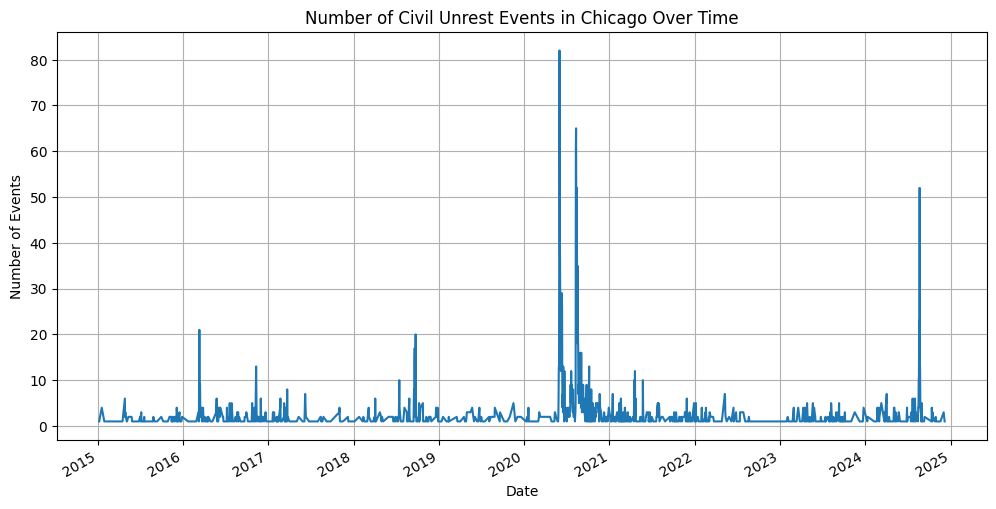

In [220]:
import matplotlib.pyplot as plt

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Plot the number of events over time
plt.figure(figsize=(12, 6))
data.groupby('SQLDATE').size().plot(kind='line')
plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

---
## Data Collection Is Effective

At this point, it's clear I've been able to collect the right data from Chicago. We're going to assume the data is clean & correct for now. I may return to review later.

## Training and Testing

At this point it would be nice to create the training and testing data. We'll train on data from 2015 to 2021 (because I want to capture the peak from COVID). In the testing data, it would be ideal to accurately predict the protest activity in mid-2024. 

Let's pull the full data set, split it, and then see how it looks to continue and understand how we would build this model.

---

In [221]:
# Updated SQL query to pull data from 2015 to today
query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20150101'
ORDER BY
    SQLDATE DESC;
"""

# Execute the updated query
query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Split the data into training and testing datasets
train_data = data[data['SQLDATE'] < '2021-01-01']
test_data = data[data['SQLDATE'] >= '2021-01-01']

# Save the results to CSV files
train_data.to_csv("chicago_violent_protests_train.csv", index=False)
test_data.to_csv("chicago_violent_protests_test.csv", index=False)

print("Training data saved to 'chicago_violent_protests_train.csv'")
print("Testing data saved to 'chicago_violent_protests_test.csv'")
print("Training data:")
print(train_data.head())
print("Testing data:")
print(test_data.head())

Training data saved to 'chicago_violent_protests_train.csv'
Testing data saved to 'chicago_violent_protests_test.csv'
Training data:
       SQLDATE EventCode                ActionGeo_FullName  ActionGeo_Lat  \
977 2020-12-29       145  Chicago, Illinois, United States          41.85   
978 2020-12-29       145  Chicago, Illinois, United States          41.85   
979 2020-12-29       145  Chicago, Illinois, United States          41.85   
980 2020-12-29       145  Chicago, Illinois, United States          41.85   
981 2020-12-24       145  Chicago, Illinois, United States          41.85   

     ActionGeo_Long   AvgTone  
977        -87.6501 -5.825243  
978        -87.6501 -9.704185  
979        -87.6501 -9.704185  
980        -87.6501 -9.704185  
981        -87.6501 -4.477296  
Testing data:
     SQLDATE EventCode                              ActionGeo_FullName  \
0 2024-12-06       145                Chicago, Illinois, United States   
1 2024-12-02       145  University Of Chicago, Ill

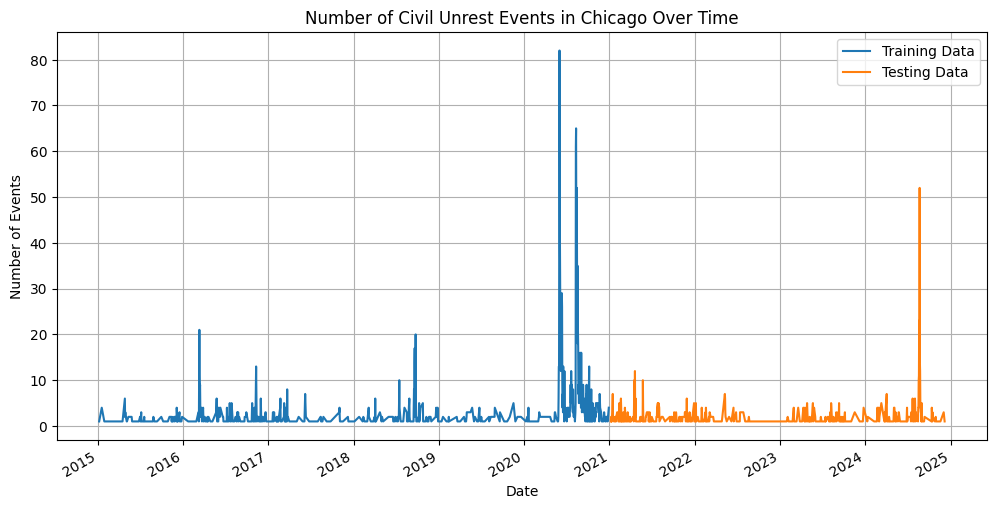

In [222]:
# Plot the number of events over time for training and testing data
plt.figure(figsize=(12, 6))

# Plot training data
train_data.groupby('SQLDATE').size().plot(kind='line', label='Training Data')

# Plot testing data
test_data.groupby('SQLDATE').size().plot(kind='line', label='Testing Data')

plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

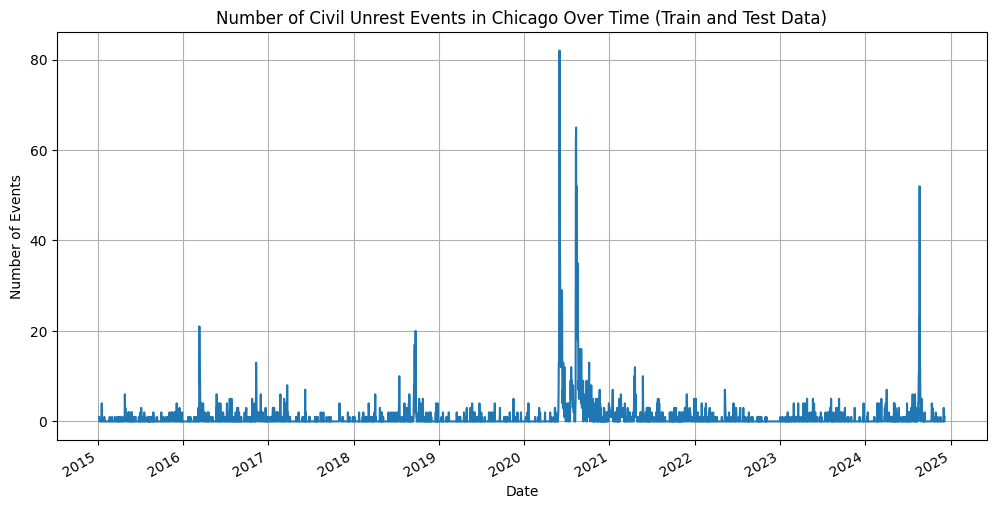

In [223]:
# Generate a date range from the start to the end of the test data
test_date_range = pd.date_range(start=test_data['SQLDATE'].min(), end=test_data['SQLDATE'].max())

# Reindex the grouped data to include all dates in the range, filling missing dates with 0 events
test_data = test_data.groupby('SQLDATE').size().reindex(test_date_range, fill_value=0)

# Generate a date range from the start to the end of the train data
train_date_range = pd.date_range(start=train_data['SQLDATE'].min(), end=train_data['SQLDATE'].max())

# Reindex the grouped data to include all dates in the range, filling missing dates with 0 events
train_data = train_data.groupby('SQLDATE').size().reindex(train_date_range, fill_value=0)

# Plot the test data
plt.figure(figsize=(12, 6))
pd.concat([train_data, test_data], axis=0).plot(kind='line')
plt.title('Number of Civil Unrest Events in Chicago Over Time (Train and Test Data)')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

---

## Comparisons with Research

### Let's see if these events show up in the data set

2015: Protests Following the Release of Laquan McDonald Video

In November 2015, the release of dashcam footage showing the police shooting of Laquan McDonald sparked widespread protests. Demonstrators blocked major intersections and disrupted shopping areas, leading to multiple arrests and instances of property damage. 

2020: George Floyd Protests

The death of George Floyd in May 2020 led to nationwide protests, with Chicago experiencing significant unrest. On May 31, the city recorded its deadliest day in at least 30 years, with 18 homicides within a 24-hour period. The violence coincided with protests that included rioting and looting, overwhelming the city's emergency response systems. 

2021: Protests Following the Killing of Adam Toledo

In April 2021, the police shooting of 13-year-old Adam Toledo resulted in protests throughout Chicago. While many demonstrations remained peaceful, there were instances of clashes between protesters and police, leading to arrests and injuries. 

2024: Democratic National Convention Protests

During the Democratic National Convention in August 2024, Chicago faced significant disruptions from pro-Palestinian protesters. These demonstrations led to confrontations with law enforcement and caused substantial disturbances in the city. 

These events highlight periods where protests in Chicago escalated into dangerous situations, impacting both public safety and city operations.

---

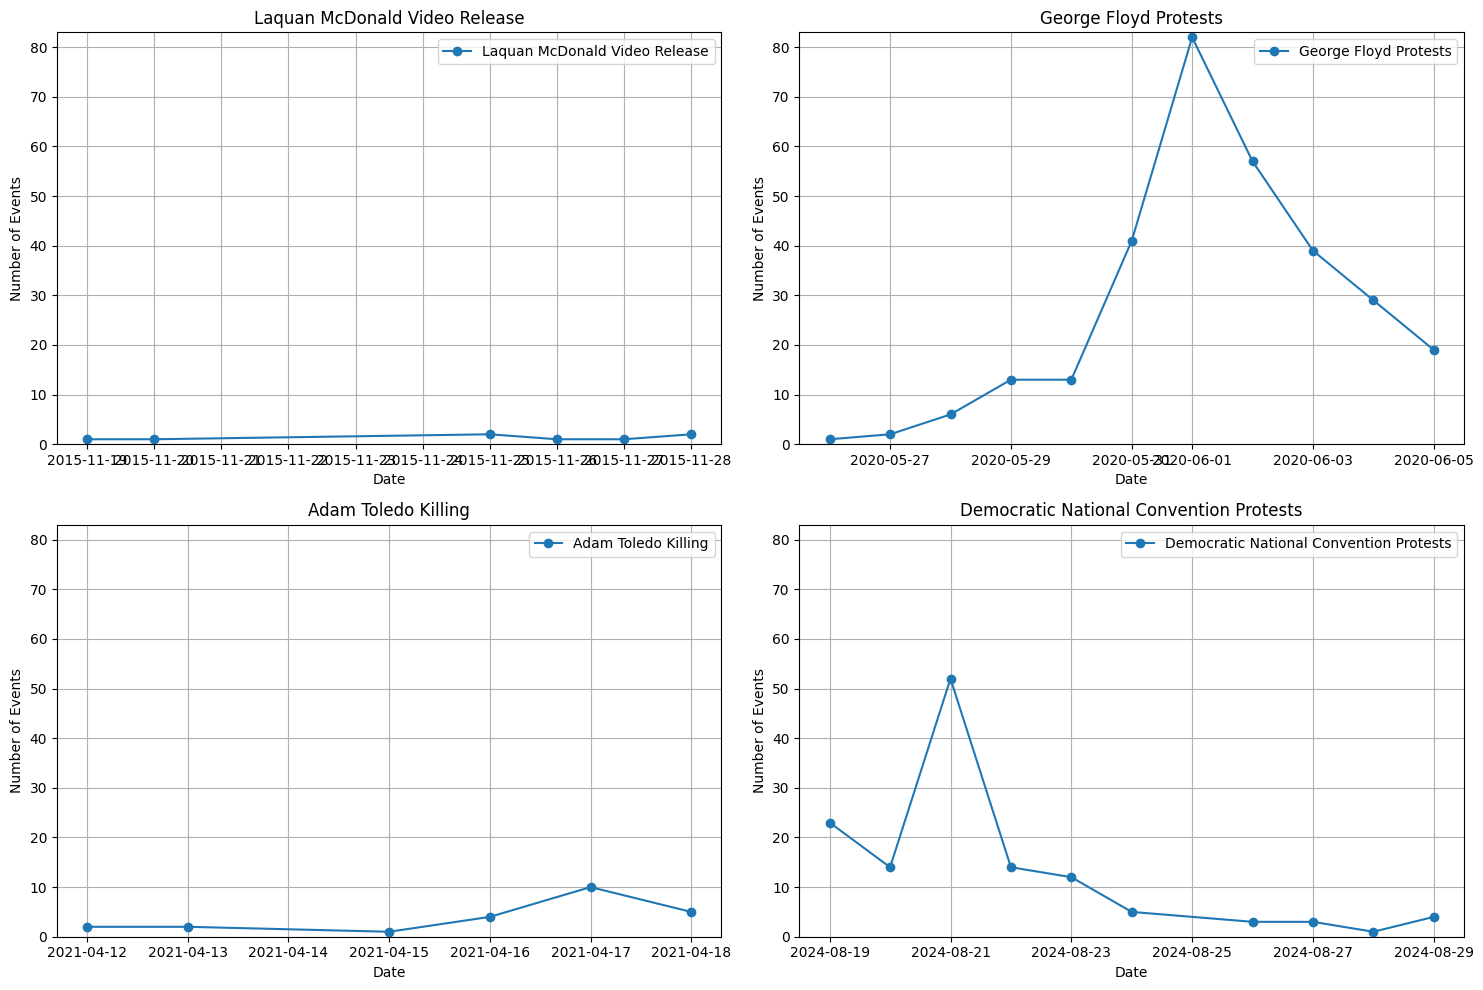

In [224]:
# Define the specific events and their dates
events = {
    "Laquan McDonald Video Release": "2015-11-24",
    "George Floyd Protests": "2020-05-31",
    "Adam Toledo Killing": "2021-04-13",
    "Democratic National Convention Protests": "2024-08-24"
}

# Convert event dates to datetime
events = {event: pd.to_datetime(date) for event, date in events.items()}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Determine the y-axis limits based on the maximum number of events in any window
max_events = 0
for event, date in events.items():
    window_data = data[(data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    max_events = max(max_events, window_data.groupby('SQLDATE').size().max())

for ax, (event, date) in zip(axes, events.items()):
    # Filter data for the 10-day window around the event
    window_data = data[(data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    
    # Group data and ensure alignment
    grouped_data = window_data.groupby('SQLDATE').size()
    ax.plot(grouped_data.index, grouped_data.values, marker='o', label=event)
    ax.set_title(event)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Events')
    ax.set_ylim(0, max_events + 1)  # Set the same y-axis limits for all subplots
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

---

It looks like half of these events were captured. With the George Floyd and DNC events being more significant, I feel confident this data is still good; however, this is where we would refine the model to define the labels better in the future.

---

---

Let's understand the distribution of civil unrest activity on a given day.

---

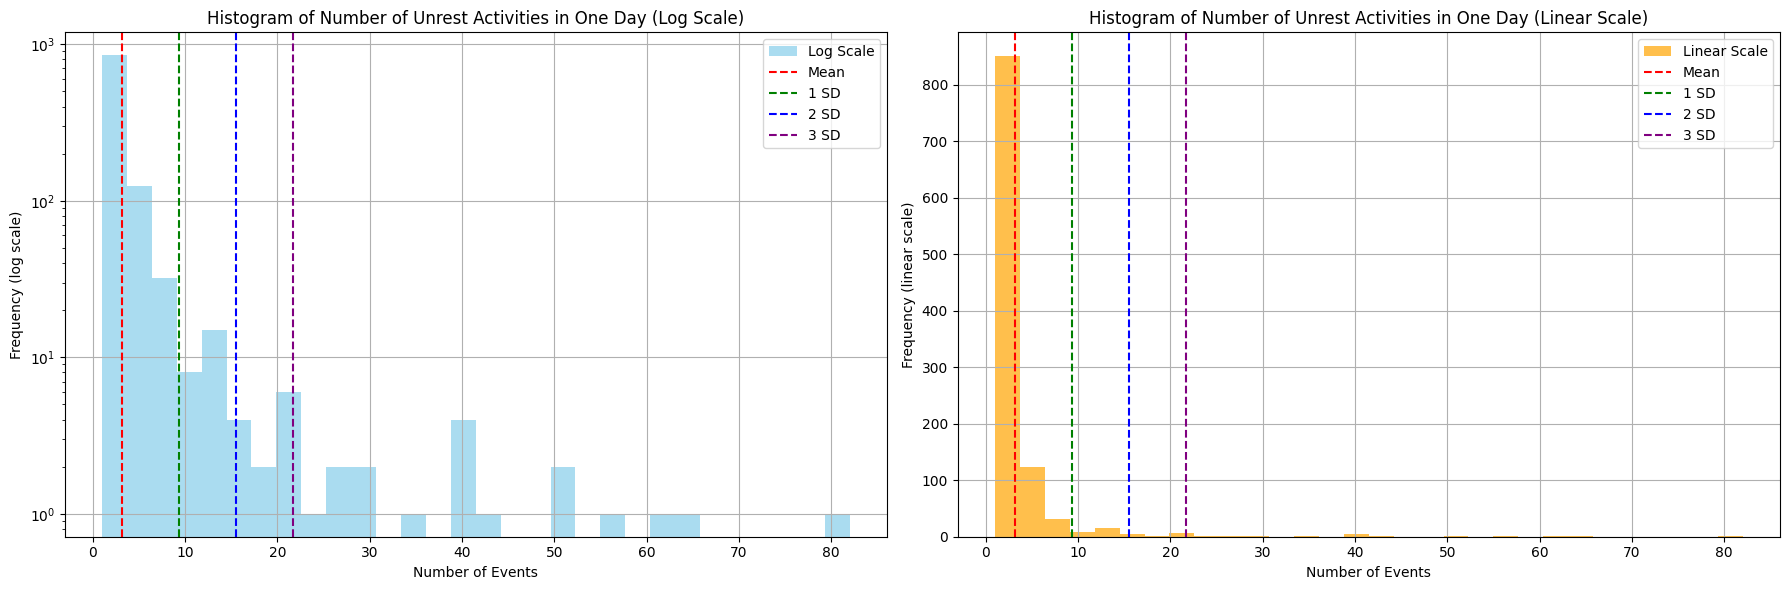

In [ ]:
import matplotlib.pyplot as plt

## THIS IS NOT CORRECT - DIDN'T ACOCUNT FOR DAYS WITHOUT EVENTS

# Group the data by date and count the number of events per day
events_per_day = data.groupby('SQLDATE').size()

# Calculate mean and standard deviation
mean_events = events_per_day.mean()
std_events = events_per_day.std()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot histogram with log scale on the first subplot
ax1.hist(events_per_day, bins=30, alpha=0.7, color='skyblue', label='Log Scale')
ax1.set_yscale('log')
ax1.set_xlabel('Number of Events')
ax1.set_ylabel('Frequency (log scale)')
ax1.set_title('Histogram of Number of Unrest Activities in One Day (Log Scale)')
ax1.grid(True)

# Plot histogram with linear scale on the second subplot
ax2.hist(events_per_day, bins=30, alpha=0.7, color='orange', label='Linear Scale')
ax2.set_xlabel('Number of Events')
ax2.set_ylabel('Frequency (linear scale)')
ax2.set_title('Histogram of Number of Unrest Activities in One Day (Linear Scale)')
ax2.grid(True)

# Add vertical lines for mean and standard deviations
for ax in [ax1, ax2]:
    ax.axvline(mean_events, color='red', linestyle='--', linewidth=1.5, label='Mean')
    ax.axvline(mean_events + std_events, color='green', linestyle='--', linewidth=1.5, label='1 SD')
    
    ax.axvline(mean_events + 2 * std_events, color='blue', linestyle='--', linewidth=1.5, label='2 SD')
    
    ax.axvline(mean_events + 3 * std_events, color='purple', linestyle='--', linewidth=1.5, label='3 SD')

# Remove duplicate legend entries
handles, labels = ax1.get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))
ax1.legend(unique_legend.values(), unique_legend.keys())

handles, labels = ax2.get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))
ax2.legend(unique_legend.values(), unique_legend.keys())

# Show the plot
plt.tight_layout()
plt.show()


---

I included a logorithmic distribution becuase clearly most days in Chicago have very few events (thank God!). I also included the SD of events in the graph, to see how rare some of the events were. However, this is not normally distributed, so it's not really the most relevant of an input.

---

---

Now I want to better understand the relationship between AvgTone and these events. 

---

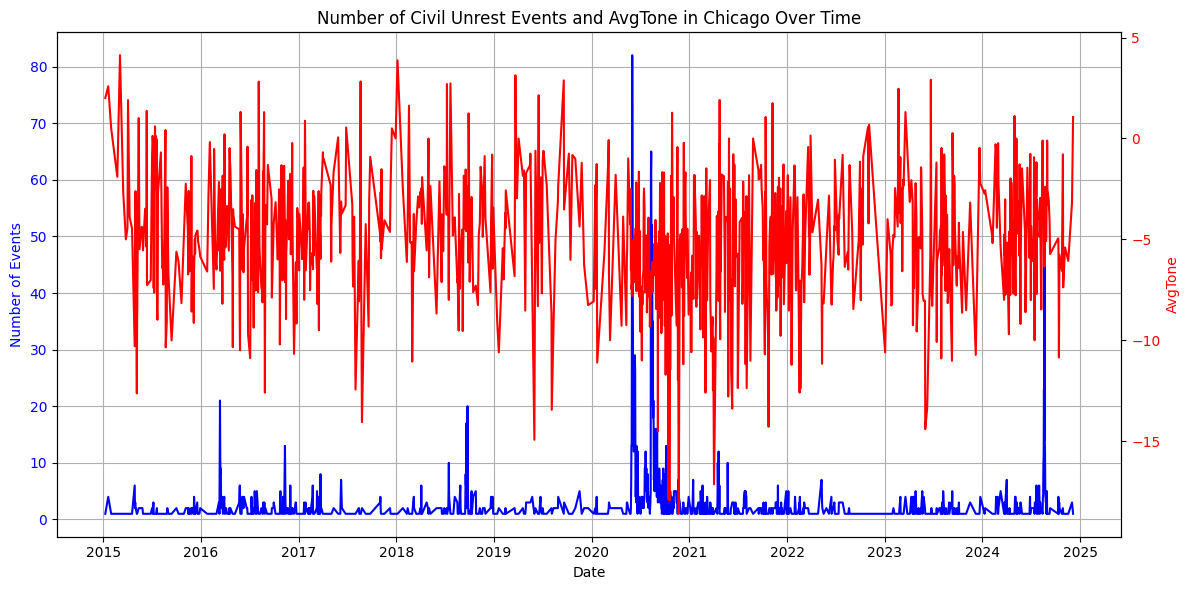

In [226]:
# Aggregate data for plotting
grouped_data = data.groupby('SQLDATE').agg({'EventCode': 'size', 'AvgTone': 'mean'}).reset_index()

# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the number of events over time
ax1.plot(grouped_data['SQLDATE'], grouped_data['EventCode'], color='blue', label='Number of Events')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Events', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot AvgTone
ax2 = ax1.twinx()
ax2.plot(grouped_data['SQLDATE'], grouped_data['AvgTone'], color='red', label='AvgTone')
ax2.set_ylabel('AvgTone', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Number of Civil Unrest Events and AvgTone in Chicago Over Time')
ax1.grid(True)

# Optimize layout and show the plot
fig.tight_layout()
plt.show()


---

## Building the Model

I considered a few ways to build this model. Here's the problems I was pondering:
* If you look at only 1 calendar day, you might split a series of civil unrest events. There's no signifigance to midnight, so why would we split the events that way?
* We should not build our model in a discrete manner. We'll model it on a rolling 24hr basis.

## Prediction Goal

I want to build a model that predicts the number of civil unrest events that will occur in the next 24 hrs.

There's many models that could work, so I think we should try a few, and choose the one that's more accurate.

Doing some reserach, I've stumbled into the "RNN" method. Let's try this one out.

---

In [227]:
test_X = []
test_Y = []
for i in range(7, len(test_data)):
    test_X.append(tuple(test_data.iloc[i-7:i]))
    test_Y.append(test_data.iloc[i])

train_X = []
train_Y = []
for i in range(7, len(train_data)):
    train_X.append((tuple(train_data.iloc[i-7:i])))
    train_Y.append(train_data.iloc[i])

In [228]:
# Convert lists to numpy arrays
import numpy as np

test_X = np.array(test_X)
test_Y = np.array(test_Y)
train_X = np.array(train_X)
train_Y = np.array(train_Y)

# Reshape the data to fit the model input requirements
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_X, train_Y, epochs=10, verbose=1)

Epoch 1/10


/Users/warrenweissbluth/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.8347
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.1171
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9775
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 8.2554
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 5.5264
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 5.8761
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 8.1294
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3683
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0920
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8578


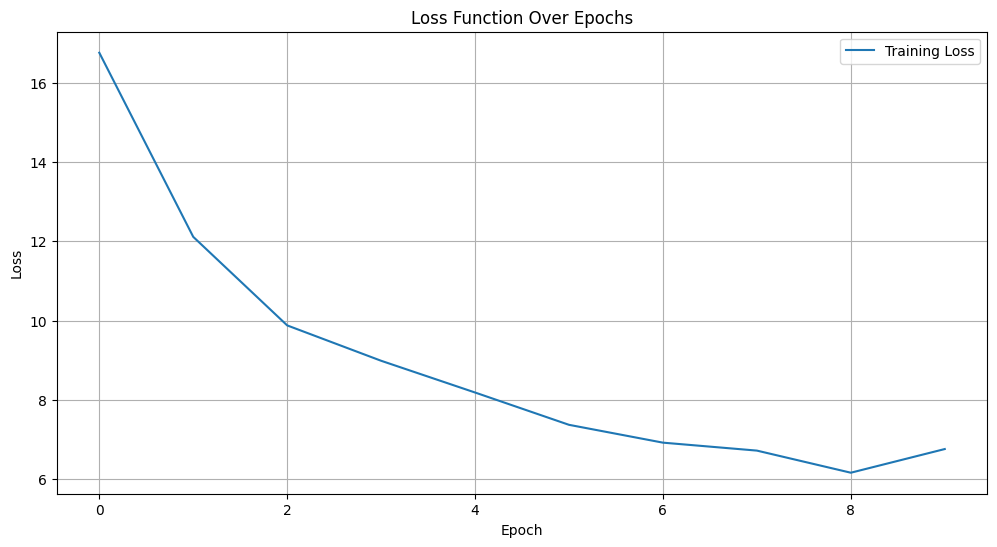

In [229]:
# Plot the loss function over the epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [230]:
# Make predictions on the test data
predictions = model.predict(test_X)

# Adjust the index to start on 2021-01-01
adjusted_index = pd.date_range(start='2021-01-01', periods=len(test_Y), freq='D')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


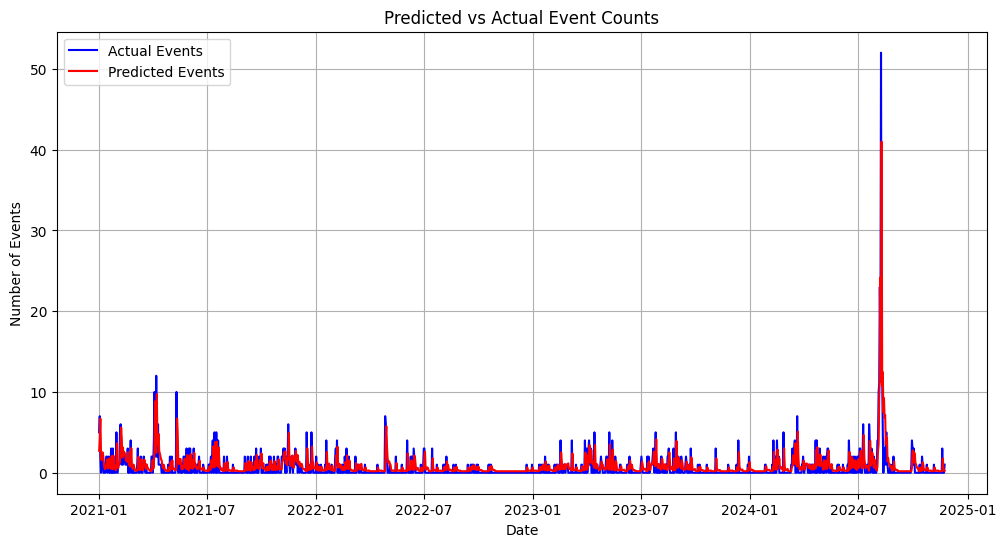

In [231]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(adjusted_index, test_Y, label='Actual Events', color='blue')
plt.plot(adjusted_index, predictions, label='Predicted Events', color='red')
plt.title('Predicted vs Actual Event Counts')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

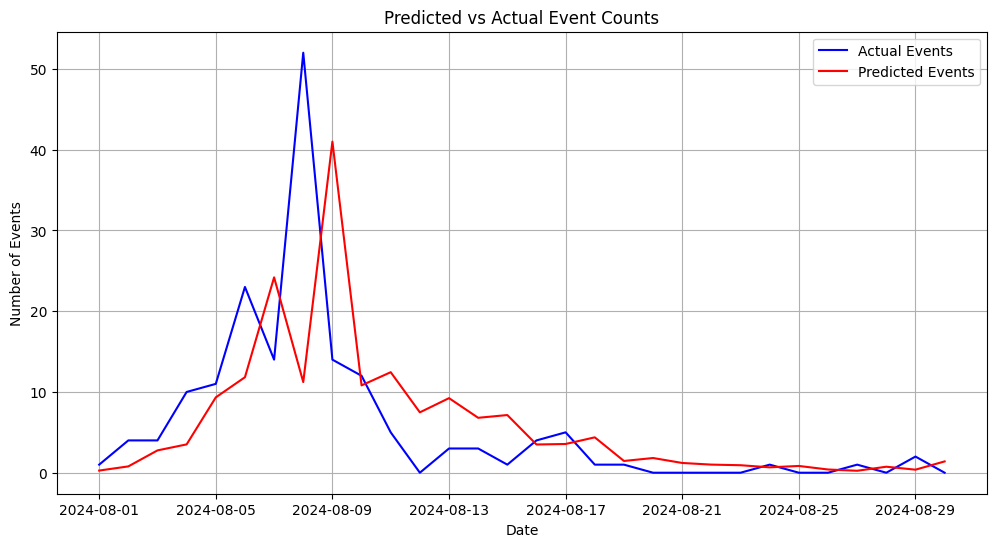

In [232]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(adjusted_index[1308:1338], test_Y[1308:1338], label='Actual Events', color='blue')
plt.plot(adjusted_index[1308:1338:], predictions[1308:1338], label='Predicted Events', color='red')
plt.title('Predicted vs Actual Event Counts')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

---

The model actually seemed to predict the DNC protests that occured in Chicago!

The greatest area for improvement in this model would be to reduce the lag in the model. It really helps when protests start to ramp up, because the model picks up on this and then predicts a growth in the civil unrest events. 

However, this almost defeats the point if you are a day late from knowing when protest peak. You already went to school or work.

I could have an off-by-1 error in my code. That would be more realistic. I'm I'm frankly pretty shocked the model was so accurate. I need to double check there's no error in the training & testing data.

If I accidentlly trained on the test data, that would be a huge error. I'll need to double check my work. 

---